In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import InputLayer, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.data import Dataset
import tensorflow as tf

import utils
from layers import FFDense
from models import FFNetwork

60000 training examples
10000 testing examples


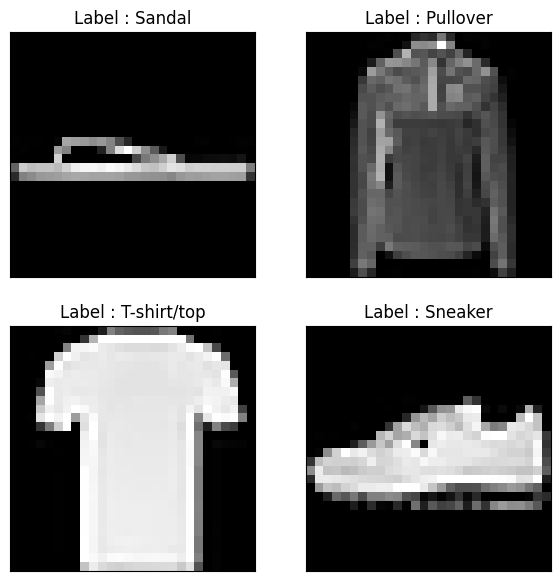

In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f'{x_train.shape[0]} training examples\n{x_test.shape[0]} testing examples')

train_dataset = Dataset.from_tensor_slices((x_train, y_train))
test_dataset = Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

utils.show_samples(x_train, y_train, class_names)

## Backpropagation Model

For comparison with the Forward-Forward algortihm

In [3]:
clf = Sequential([InputLayer(input_shape=(28, 28)),
                  Flatten(),
                  Dense(10, activation='softmax')])
clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
938/938 [==============================] - 2s 1ms/step - loss: 0.6609 - accuracy: 0.7784
Epoch 2/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4834 - accuracy: 0.8368
Epoch 3/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4502 - accuracy: 0.8472
Epoch 4/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4329 - accuracy: 0.8523
Epoch 5/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8554
Epoch 6/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4139 - accuracy: 0.8574
Epoch 7/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4079 - accuracy: 0.8595
Epoch 8/100
938/938 [==============================] - 1s 1ms/step - loss: 0.4031 - accuracy: 0.8607
Epoch 9/100
938/938 [==============================] - 1s 1ms/step - loss: 0.3991 - accuracy: 0.8622
Epoch 10/100
938/938 [==============================] - 1s 1ms/step - loss: 0.3957 - accura

## Evaluate the back propagation model

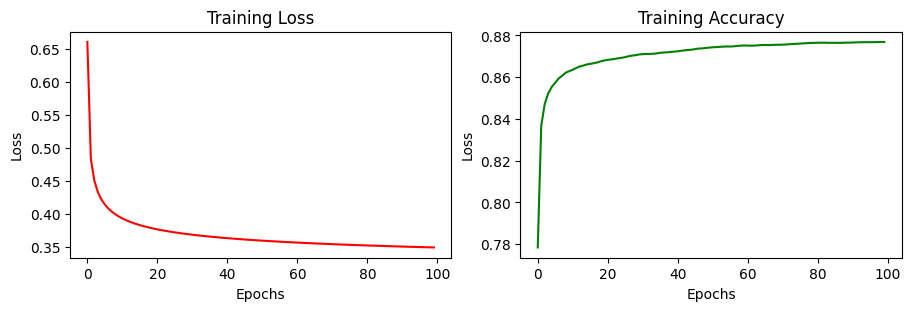

In [4]:
utils.plot_history(history.history)

157/157 [==============================] - 0s 1ms/step
 Accuracy = 84.16%


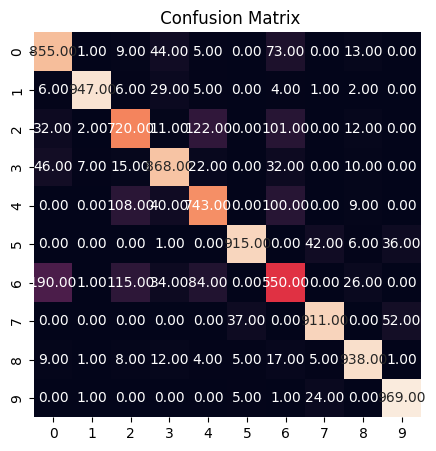

In [5]:
preds = clf.predict(test_dataset, verbose=1)
pred_labels = np.argmax(preds, axis=1)
utils.evaluate(y_test, pred_labels, figsize=5)

Look at misclassified examples

Predicted: T-shirt/top Actual: Shirt


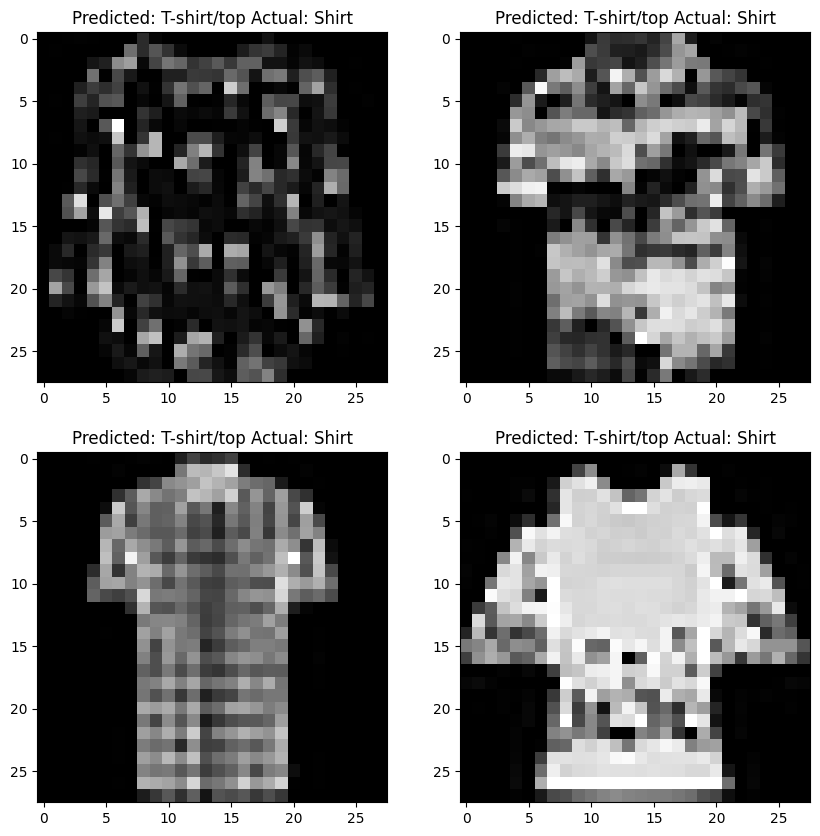

Predicted: Coat Actual: Pullover


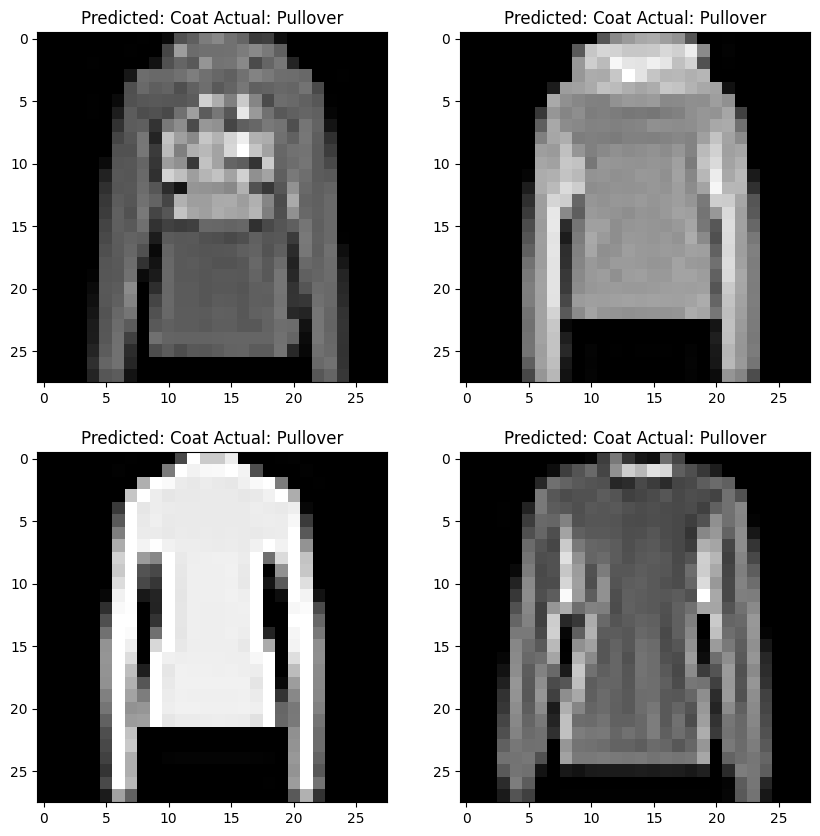

Predicted: Pullover Actual: Shirt


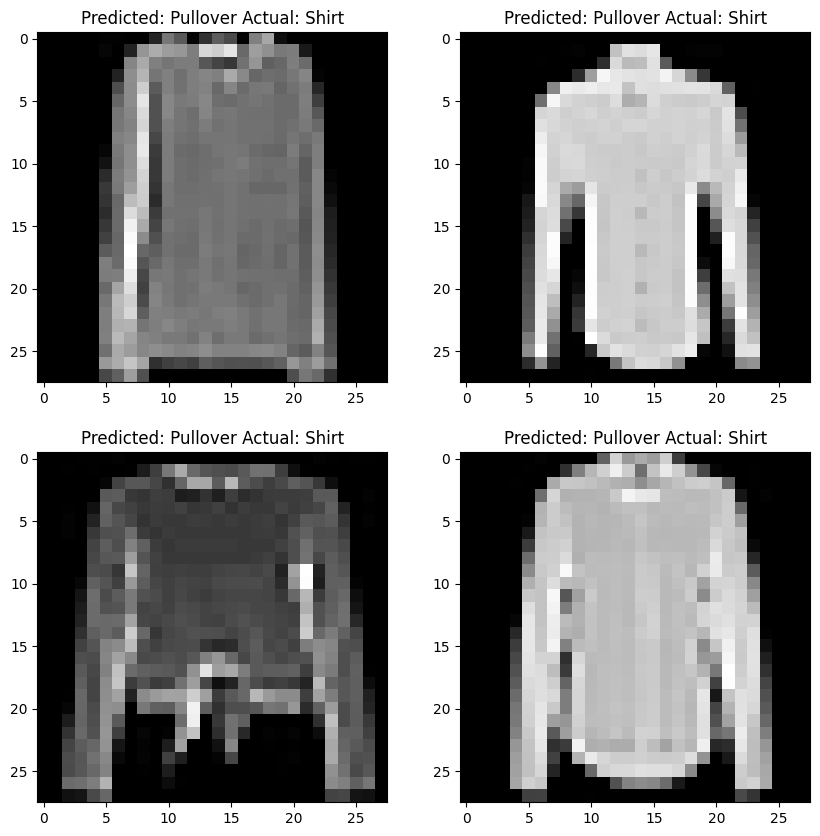

Predicted: Pullover Actual: Coat


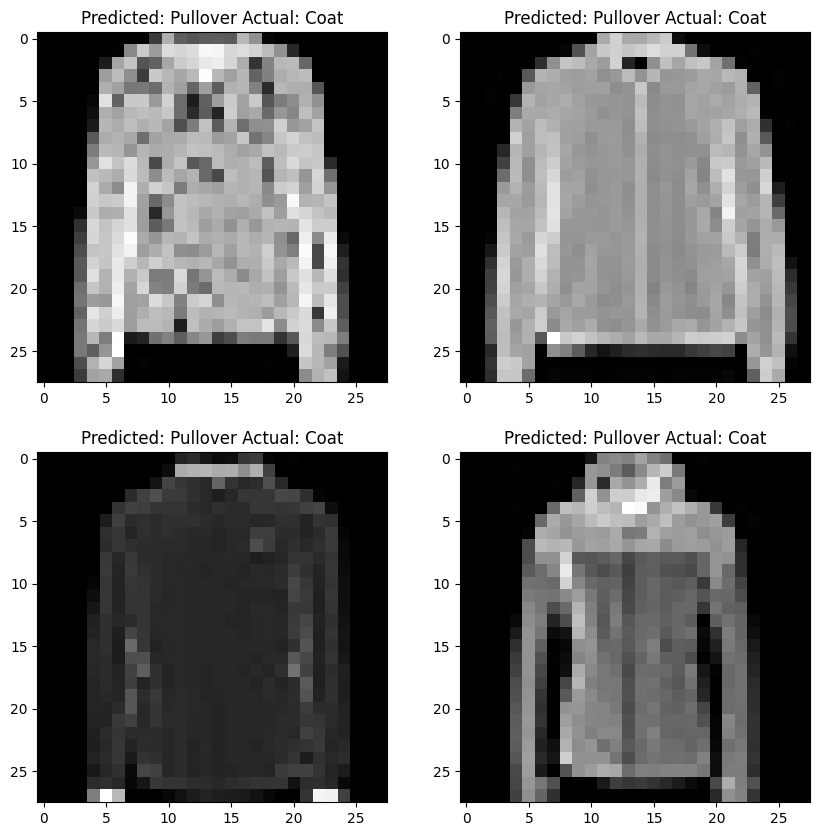

In [6]:
y_hat = np.squeeze(pred_labels)
misses_df, top_errors = utils.get_worst(y_hat, y_test, 4)

data = (x_test, y_hat, y_test)

for predicted, actual in top_errors.index.tolist():
    print(f'Predicted: {class_names[predicted]} Actual: {class_names[actual]}')
    utils.compare(predicted, actual, data, misses_df, classes=class_names)

## Build and train the Forward-Foward model!

In [9]:
model = FFNetwork([784, 10], iterations=1)

model.compile(
    optimizer=Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[Mean()],
)

In [10]:
history = model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
Training layer 1 now : 
Training layer 1 now : 
938/938 [==============================] - 4s 3ms/step - FinalLoss: 0.6670
Epoch 2/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.5708
Epoch 3/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.5239
Epoch 4/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4974
Epoch 5/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4798
Epoch 6/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.4670
Epoch 7/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4573
Epoch 8/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.4490
Epoch 9/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4421
Epoch 10/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4361
Epoch 11/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 

## Model Evaluation

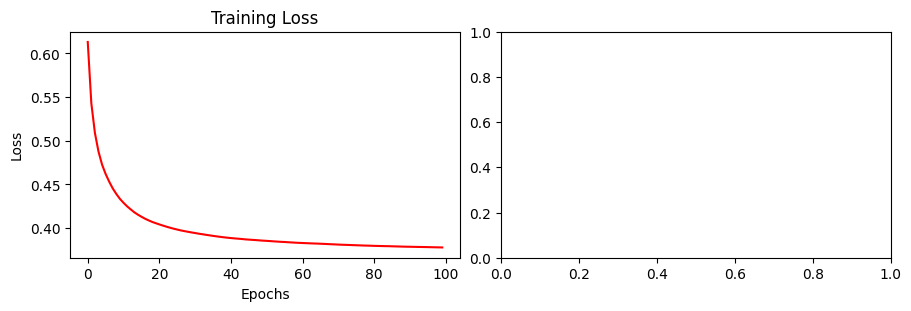

In [15]:
hist = {'loss': history.history['FinalLoss']}
utils.plot_history(hist)

 Accuracy = 76.70%


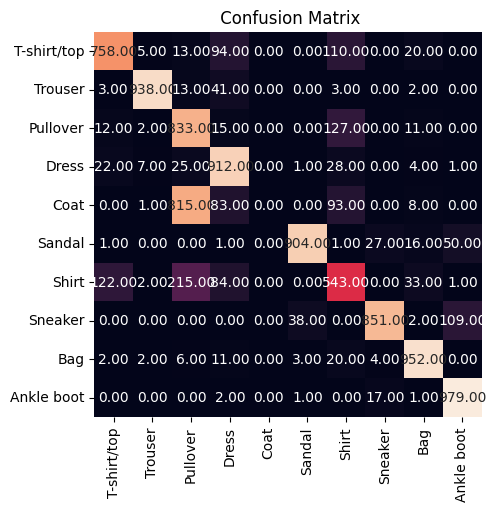

In [17]:
preds = model.predict(tf.convert_to_tensor(x_test))
preds = preds.reshape((preds.shape[0], preds.shape[1]))
utils.evaluate(y_test, preds, class_names, figsize=5)

### Looking at the errors (top 4 missclassifications)

Predicted: 0 Actual: 6


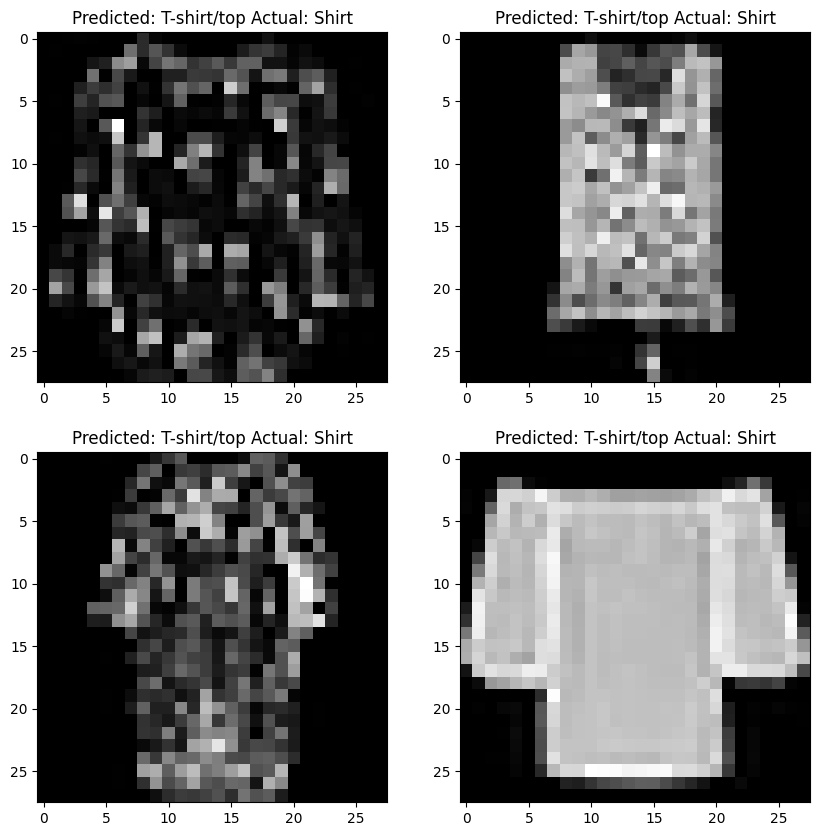

Predicted: 4 Actual: 2


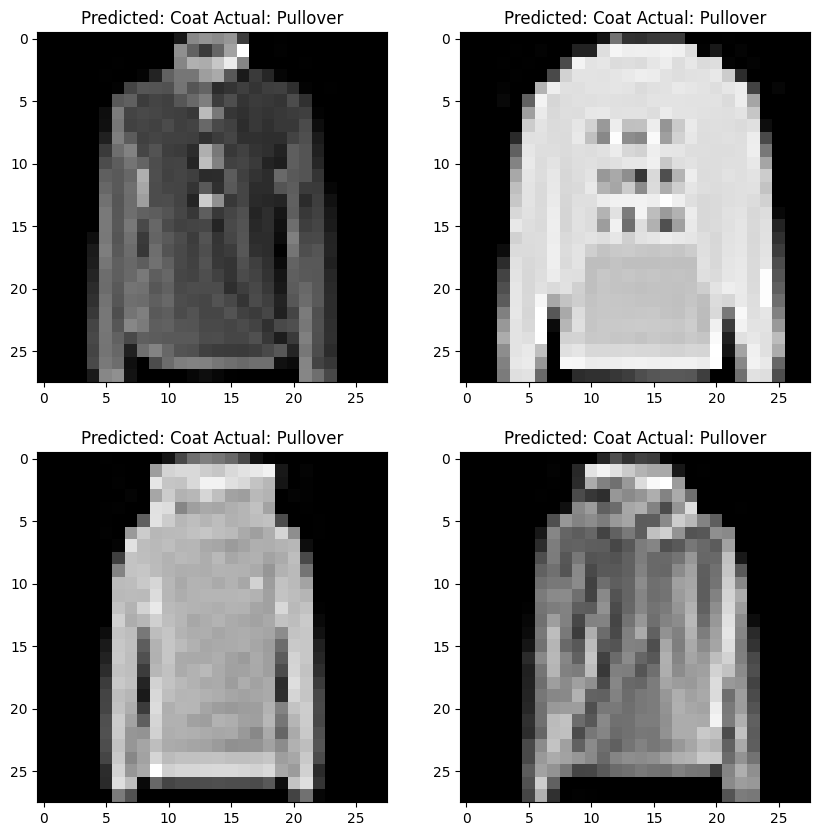

Predicted: 2 Actual: 6


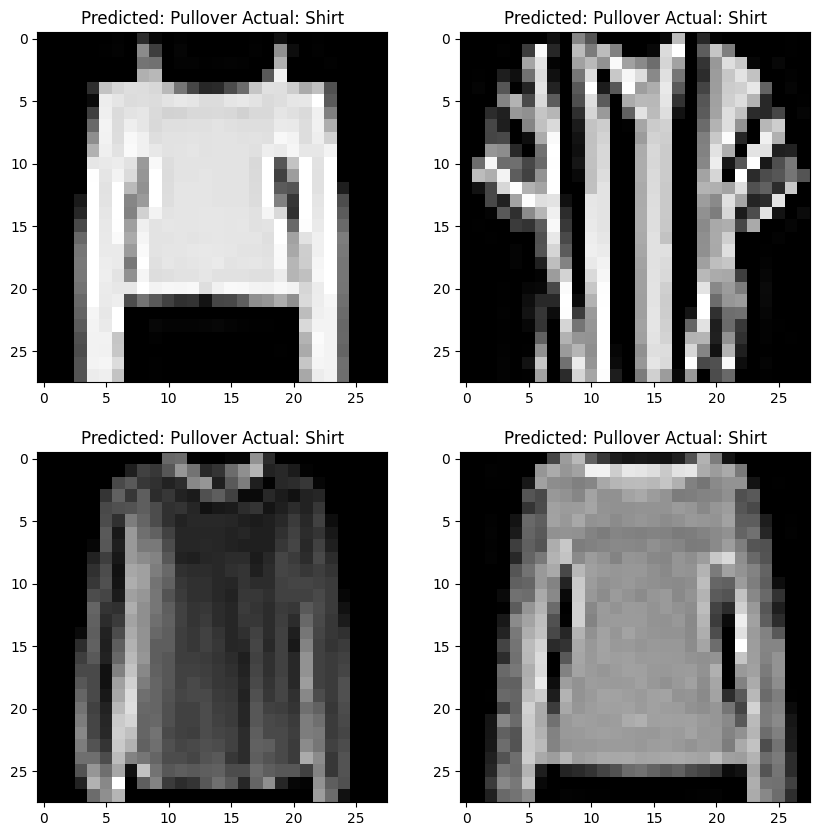

Predicted: 2 Actual: 4


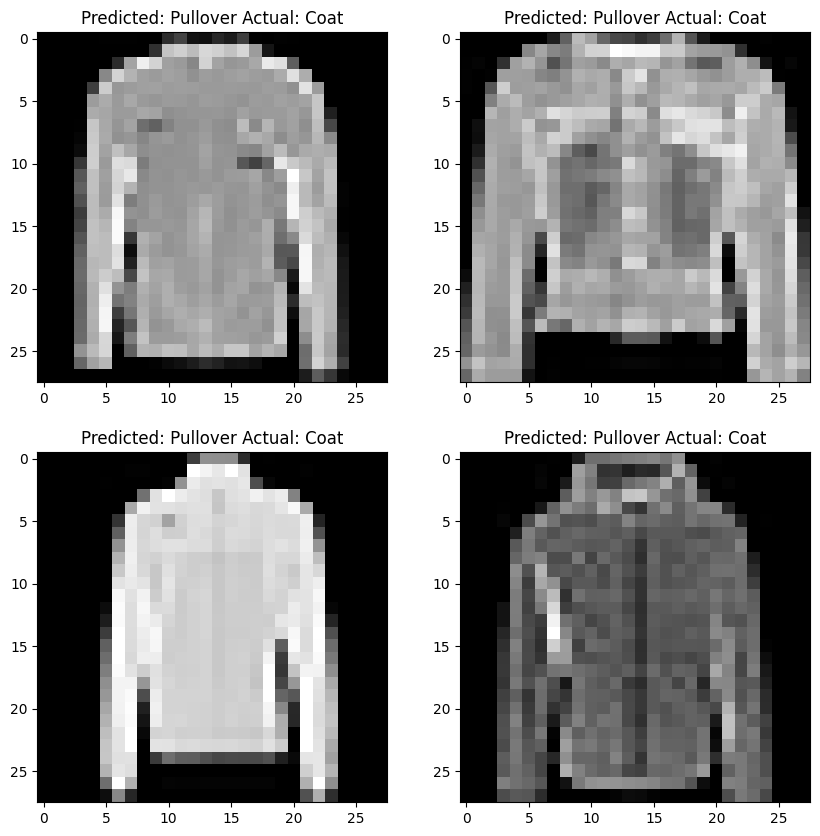

In [19]:
y_hat = np.squeeze(pred_labels)
misses_df, top_errors = utils.get_worst(y_hat, y_test, 4)

data = (x_test, y_hat, y_test)

for predicted, actual in top_errors.index.tolist():
    print(f'Predicted: {predicted} Actual: {actual}')
    utils.compare(predicted, actual, data, misses_df, classes=class_names)